<a href="https://colab.research.google.com/github/kkrphm/project-Models/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [ ]:
# For Data Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.utils  import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score,roc_auc_score, classification_report,roc_curve, auc
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array,ImageDataGenerator, load_img
from keras.utils import np_utils
from tensorflow.keras.utils  import to_categorical
from numpy import expand_dims
from sklearn.preprocessing import LabelBinarizer


# For DL Models
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,LayerNormalization, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model,load_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# For Data Visualization
import seaborn as sns
import cv2
%matplotlib inline
import matplotlib.pyplot as plt #used for plotting and analyzing data
import matplotlib
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': True,
              'legend.fontsize': 14,
              'legend.title_fontsize': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'axes.labelsize': 16,
              'axes.titlesize': 20,
              'axes.linewidth':'1',
              'axes.edgecolor':'0',
              'figure.dpi': 600
               }

# Miscellaneous       
import random
import warnings
warnings.filterwarnings("ignore")
import os #file I/O

## **Training & Validation Datasets**

In [ ]:
train_data_dir = '/content/drive/MyDrive/Project (1)/Brain_Tumor/Training' #data is already in colab file
validation_data_dir = '/content/drive/MyDrive/Project (1)/Brain_Tumor/Testing'
test_data_dir='/content/drive/MyDrive/Project (1)/Brain_Tumor/Testing'
nb_train_samples =488
nb_validation_samples =169
nb_test_samples =153
epochs = 60
batch_size = 64
num_classes=4
# input image dimensions
img_rows, img_cols = 224,224

# **Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1. / 255,
  shear_range=0.2,
  zoom_range=0.2,
  rotation_range=2,
  horizontal_flip=True,
  vertical_flip=True
  )

val_datagen = ImageDataGenerator(
  rescale=1. / 255,
  shear_range=0.2,
  zoom_range=0.2,
  rotation_range=2,
  horizontal_flip=True,
  vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False
  )

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# **Data Visualization**

In [ ]:
index = ['glioma','meningioma','notumor','pituitary']
trained_classes=[]
for i in train_generator.classes:
  trained_classes.append(index[i])
print(trained_classes[:5])
test_classes=[]
for i in test_generator.classes:
  test_classes.append(index[i])
print(test_classes[:5])

['glioma', 'glioma', 'glioma', 'glioma', 'glioma']
['glioma', 'glioma', 'glioma', 'glioma', 'glioma']


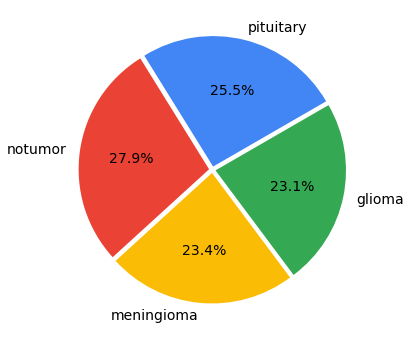

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in trained_classes if x=='pituitary']),
         len([x for x in trained_classes if x=='notumor']),
         len([x for x in trained_classes if x=='meningioma']),
         len([x for x in trained_classes if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

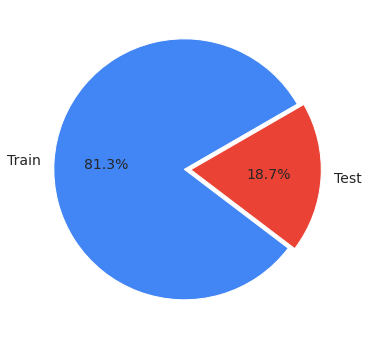

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(trained_classes), len(test_classes)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# **Augmented Images**

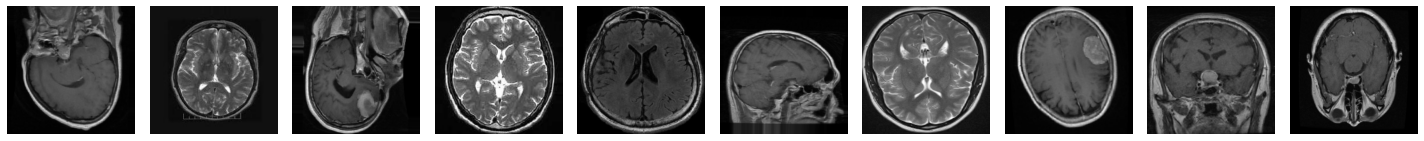

In [ ]:
# next function iterates over the training set and separates the images and their labels 
imgs, labels = next(train_generator)

#we define a function that prints the first 10 images from the training set 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
# calling our function to print the first 10 images
plotImages(imgs)
# printing all the labels from the first batch of 32 images


# **Download Pre-trained model(VGG16)**

In [ ]:
vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
len(vgg_model.layers)

19

## **Model Layers Freezing**

In [ ]:
# Set all layers to non-trainable
for layer in vgg_model.layers[:18]:
    layer.trainable = False

for layer in vgg_model.layers[18:]:
    layer.trainable = True

## **Add more layers**

**To convert 16-class classification model into 4-class classification model**

In [ ]:
model = Sequential()
model.add(Input(shape=(img_rows, img_cols,3)))
model.add(vgg_model)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_4 (Dropout)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 3,211,908
N

# **Model Compilation**

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy','AUC'])

# **Set Checkpoint to save model at every 640 epoches**

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Project (1)/VGG/wm_save"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=10*batch_size,
                                                 verbose=1)

## **Model fitting**

In [ ]:
history=model.fit(train_generator, 
          epochs=20,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/20
90/90 [==============================] - 532s 6s/step - loss: 0.7845 - accuracy: 0.6780 - auc: 0.8944 - val_loss: 0.5939 - val_accuracy: 0.7811 - val_auc: 0.9394
Epoch 2/20
90/90 [==============================] - 96s 1s/step - loss: 0.4955 - accuracy: 0.8118 - auc: 0.9580 - val_loss: 0.5022 - val_accuracy: 0.8139 - val_auc: 0.9558
Epoch 3/20
90/90 [==============================] - 97s 1s/step - loss: 0.4157 - accuracy: 0.8470 - auc: 0.9696 - val_loss: 0.4867 - val_accuracy: 0.8146 - val_auc: 0.9591
Epoch 4/20
90/90 [==============================] - 96s 1s/step - loss: 0.3757 - accuracy: 0.8647 - auc: 0.9749 - val_loss: 0.4134 - val_accuracy: 0.8391 - val_auc: 0.9692
Epoch 5/20
90/90 [==============================] - 97s 1s/step - loss: 0.3492 - accuracy: 0.8754 - auc: 0.9783 - val_loss: 0.4198 - val_accuracy: 0.8421 - val_auc: 0.9696
Epoch 6/20
90/90 [==============================] - 97s 1s/step - loss: 0.3332 - accuracy: 0.8794 - auc: 0.9799 - val_loss: 0.3784 - val_ac

## **Model evaluation**

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)


21/21 [==============================] - 7s 318ms/step - loss: 0.2805 - accuracy: 0.8886 - auc: 0.9868
Test loss: 0.28046485781669617
Test accuracy: 0.8886346220970154


# **Model Save**

In [ ]:
#Saving the weight of the model
model.save('/content/drive/MyDrive/vgg16/'+str(a1)+'bt1.h5')

# **Progess of Model accuracy & Loss**

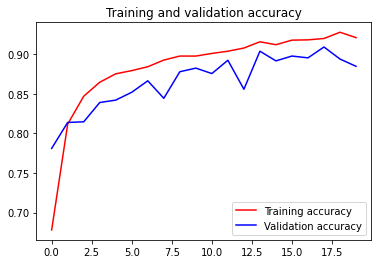

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc =history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

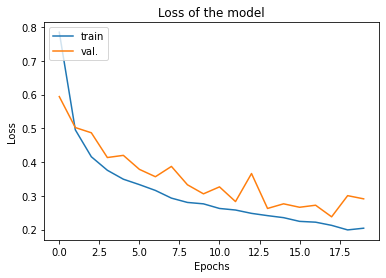

In [ ]:
# comparing training and testing loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

# **Model Retraining**

In [ ]:
history2=model.fit(train_generator, 
          epochs=50,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/50
90/90 [==============================] - 103s 1s/step - loss: 0.2021 - accuracy: 0.9270 - auc: 0.9924 - val_loss: 0.2860 - val_accuracy: 0.8871 - val_auc: 0.9857
Epoch 2/50
29/90 [========>.....................] - ETA: 54s - loss: 0.2045 - accuracy: 0.9294 - auc: 0.9921
Epoch 2: saving model to /content/drive/MyDrive/Project (1)/VGG/wm_save
90/90 [==============================] - 100s 1s/step - loss: 0.1979 - accuracy: 0.9307 - auc: 0.9927 - val_loss: 0.2138 - val_accuracy: 0.9214 - val_auc: 0.9916
Epoch 3/50
90/90 [==============================] - 97s 1s/step - loss: 0.1901 - accuracy: 0.9326 - auc: 0.9932 - val_loss: 0.2432 - val_accuracy: 0.8986 - val_auc: 0.9888
Epoch 4/50
90/90 [==============================] - 97s 1s/step - loss: 0.1880 - accuracy: 0.9317 - auc: 0.9936 - val_loss: 0.2347 - val_accuracy: 0.9123 - val_auc: 0.9897
Epoch 5/50
90/90 [==============================] - 97s 1s/step - loss: 0.1911 - accuracy: 0.9298 - auc: 0.9931 - val_loss: 0.2266 - val_acc

# **Retrained Model Evaluation**

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/vgg16/'+str(a1)+'bt1.h5')

21/21 [==============================] - 7s 315ms/step - loss: 0.1015 - accuracy: 0.9611 - auc: 0.9980
Test loss: 0.10151593387126923
Test accuracy: 0.9610983729362488


## **Retrained Model Accuracy & Loss Progress**

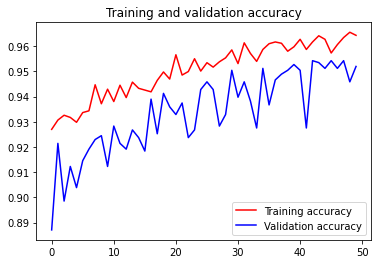

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history2.history['accuracy']
val_acc =history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

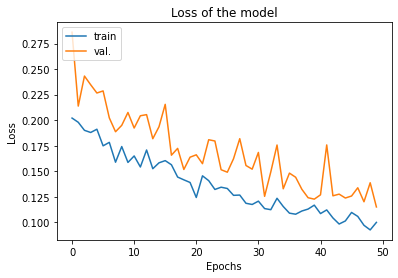

In [ ]:
# comparing training and testing loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

# **Continue Model Training and Evaluation  for more epoches.**

In [ ]:
history3=model.fit(train_generator, 
          epochs=50,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/50
90/90 [==============================] - 98s 1s/step - loss: 0.0982 - accuracy: 0.9638 - auc: 0.9980 - val_loss: 0.1256 - val_accuracy: 0.9489 - val_auc: 0.9970
Epoch 2/50
 9/90 [==>...........................] - ETA: 1:11 - loss: 0.1140 - accuracy: 0.9566 - auc: 0.9974
Epoch 2: saving model to /content/drive/MyDrive/Project (1)/VGG/wm_save
90/90 [==============================] - 97s 1s/step - loss: 0.0983 - accuracy: 0.9648 - auc: 0.9981 - val_loss: 0.1266 - val_accuracy: 0.9497 - val_auc: 0.9970
Epoch 3/50
90/90 [==============================] - 96s 1s/step - loss: 0.0929 - accuracy: 0.9662 - auc: 0.9981 - val_loss: 0.1152 - val_accuracy: 0.9535 - val_auc: 0.9975
Epoch 4/50
90/90 [==============================] - 97s 1s/step - loss: 0.1018 - accuracy: 0.9634 - auc: 0.9981 - val_loss: 0.1221 - val_accuracy: 0.9474 - val_auc: 0.9972
Epoch 5/50
90/90 [==============================] - 96s 1s/step - loss: 0.0840 - accuracy: 0.9739 - auc: 0.9986 - val_loss: 0.0982 - val_accu

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/vgg16/'+str(a1)+'bt1.h5')

21/21 [==============================] - 7s 299ms/step - loss: 0.1432 - accuracy: 0.9436 - auc: 0.9961
Test loss: 0.14321249723434448
Test accuracy: 0.9435545206069946


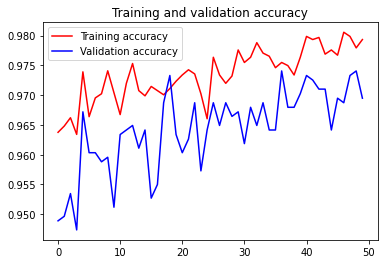

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history3.history['accuracy']
val_acc =history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

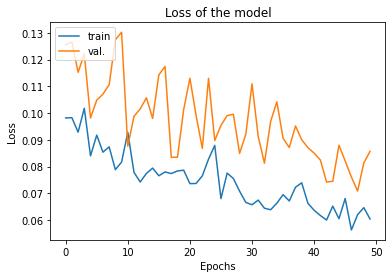

In [ ]:
# comparing training and testing loss 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
history4=model.fit(train_generator, 
          epochs=50,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/50
79/90 [=========================>....] - ETA: 9s - loss: 0.0627 - accuracy: 0.9762 - auc: 0.9993 
Epoch 1: saving model to /content/drive/MyDrive/Project (1)/VGG/wm_save
90/90 [==============================] - 99s 1s/step - loss: 0.0622 - accuracy: 0.9771 - auc: 0.9993 - val_loss: 0.0802 - val_accuracy: 0.9741 - val_auc: 0.9987
Epoch 2/50
90/90 [==============================] - 97s 1s/step - loss: 0.0540 - accuracy: 0.9827 - auc: 0.9993 - val_loss: 0.0686 - val_accuracy: 0.9718 - val_auc: 0.9991
Epoch 3/50
90/90 [==============================] - 96s 1s/step - loss: 0.0582 - accuracy: 0.9800 - auc: 0.9993 - val_loss: 0.0897 - val_accuracy: 0.9710 - val_auc: 0.9975
Epoch 4/50
90/90 [==============================] - 96s 1s/step - loss: 0.0558 - accuracy: 0.9804 - auc: 0.9994 - val_loss: 0.0729 - val_accuracy: 0.9756 - val_auc: 0.9989
Epoch 5/50
90/90 [==============================] - 96s 1s/step - loss: 0.0585 - accuracy: 0.9800 - auc: 0.9993 - val_loss: 0.0750 - val_accur

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/vgg16/'+str(a1)+'bt1.h5')

21/21 [==============================] - 6s 285ms/step - loss: 0.0567 - accuracy: 0.9825 - auc: 0.9990
Test loss: 0.05674641951918602
Test accuracy: 0.9824561476707458


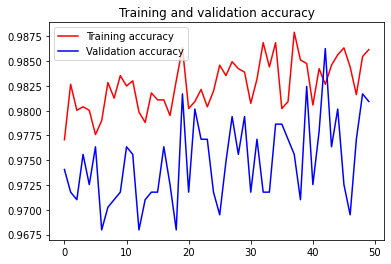

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history4.history['accuracy']
val_acc =history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

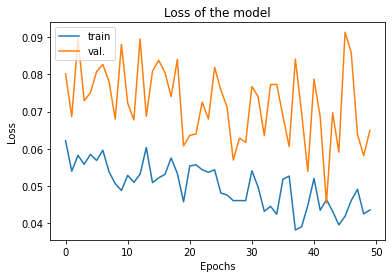

In [ ]:
# comparing training and testing loss 
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
history4=model.fit(train_generator, 
          epochs=25,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/25
59/90 [==================>...........] - ETA: 26s - loss: 0.0381 - accuracy: 0.9868 - auc: 0.9996
Epoch 1: saving model to /content/drive/MyDrive/Project (1)/VGG/wm_save
90/90 [==============================] - 98s 1s/step - loss: 0.0437 - accuracy: 0.9834 - auc: 0.9995 - val_loss: 0.0839 - val_accuracy: 0.9725 - val_auc: 0.9979
Epoch 2/25
90/90 [==============================] - 97s 1s/step - loss: 0.0384 - accuracy: 0.9870 - auc: 0.9997 - val_loss: 0.0755 - val_accuracy: 0.9779 - val_auc: 0.9978
Epoch 3/25
90/90 [==============================] - 96s 1s/step - loss: 0.0404 - accuracy: 0.9863 - auc: 0.9995 - val_loss: 0.0715 - val_accuracy: 0.9741 - val_auc: 0.9986
Epoch 4/25
90/90 [==============================] - 96s 1s/step - loss: 0.0433 - accuracy: 0.9842 - auc: 0.9995 - val_loss: 0.1057 - val_accuracy: 0.9626 - val_auc: 0.9973
Epoch 5/25
90/90 [==============================] - 95s 1s/step - loss: 0.0409 - accuracy: 0.9851 - auc: 0.9997 - val_loss: 0.0708 - val_accur

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/vgg16/'+str(a1)+'bt1.h5')

21/21 [==============================] - 7s 310ms/step - loss: 0.0764 - accuracy: 0.9733 - auc: 0.9982
Test loss: 0.07644758373498917
Test accuracy: 0.9733028411865234


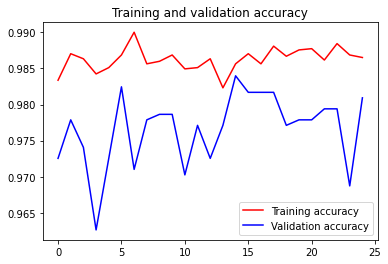

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history4.history['accuracy']
val_acc =history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

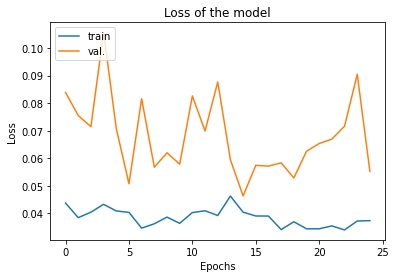

In [ ]:
# comparing training and testing loss 
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

## **Load the High Accuracy Model for Testing.**

In [ ]:
model_nw=load_model('/content/drive/MyDrive/vgg16/98.25bt1.h5')

# **Model Evaluation**

# **Accuracy Score**

In [ ]:
score = model_nw.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 474s 22s/step - loss: 0.0567 - accuracy: 0.9825 - auc: 0.9990
Test loss: 0.0567464642226696
Test accuracy: 0.9824561476707458


# **confusion_matrix**

In [ ]:
pred_test = model_nw.predict(test_generator, verbose=1)

21/21 [==============================] - 451s 21s/step


In [ ]:
classes=list(train_generator.class_indices.keys())


predict_labels_Test
Numbre of glioma : 288
Numbre of meningioma : 312
Numbre of notumor : 407
Numbre of pituitary : 304

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       288
           1       0.98      0.96      0.97       312
           2       1.00      1.00      1.00       407
           3       1.00      0.98      0.99       304

   micro avg       0.98      0.98      0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311
 samples avg       0.98      0.98      0.98      1311



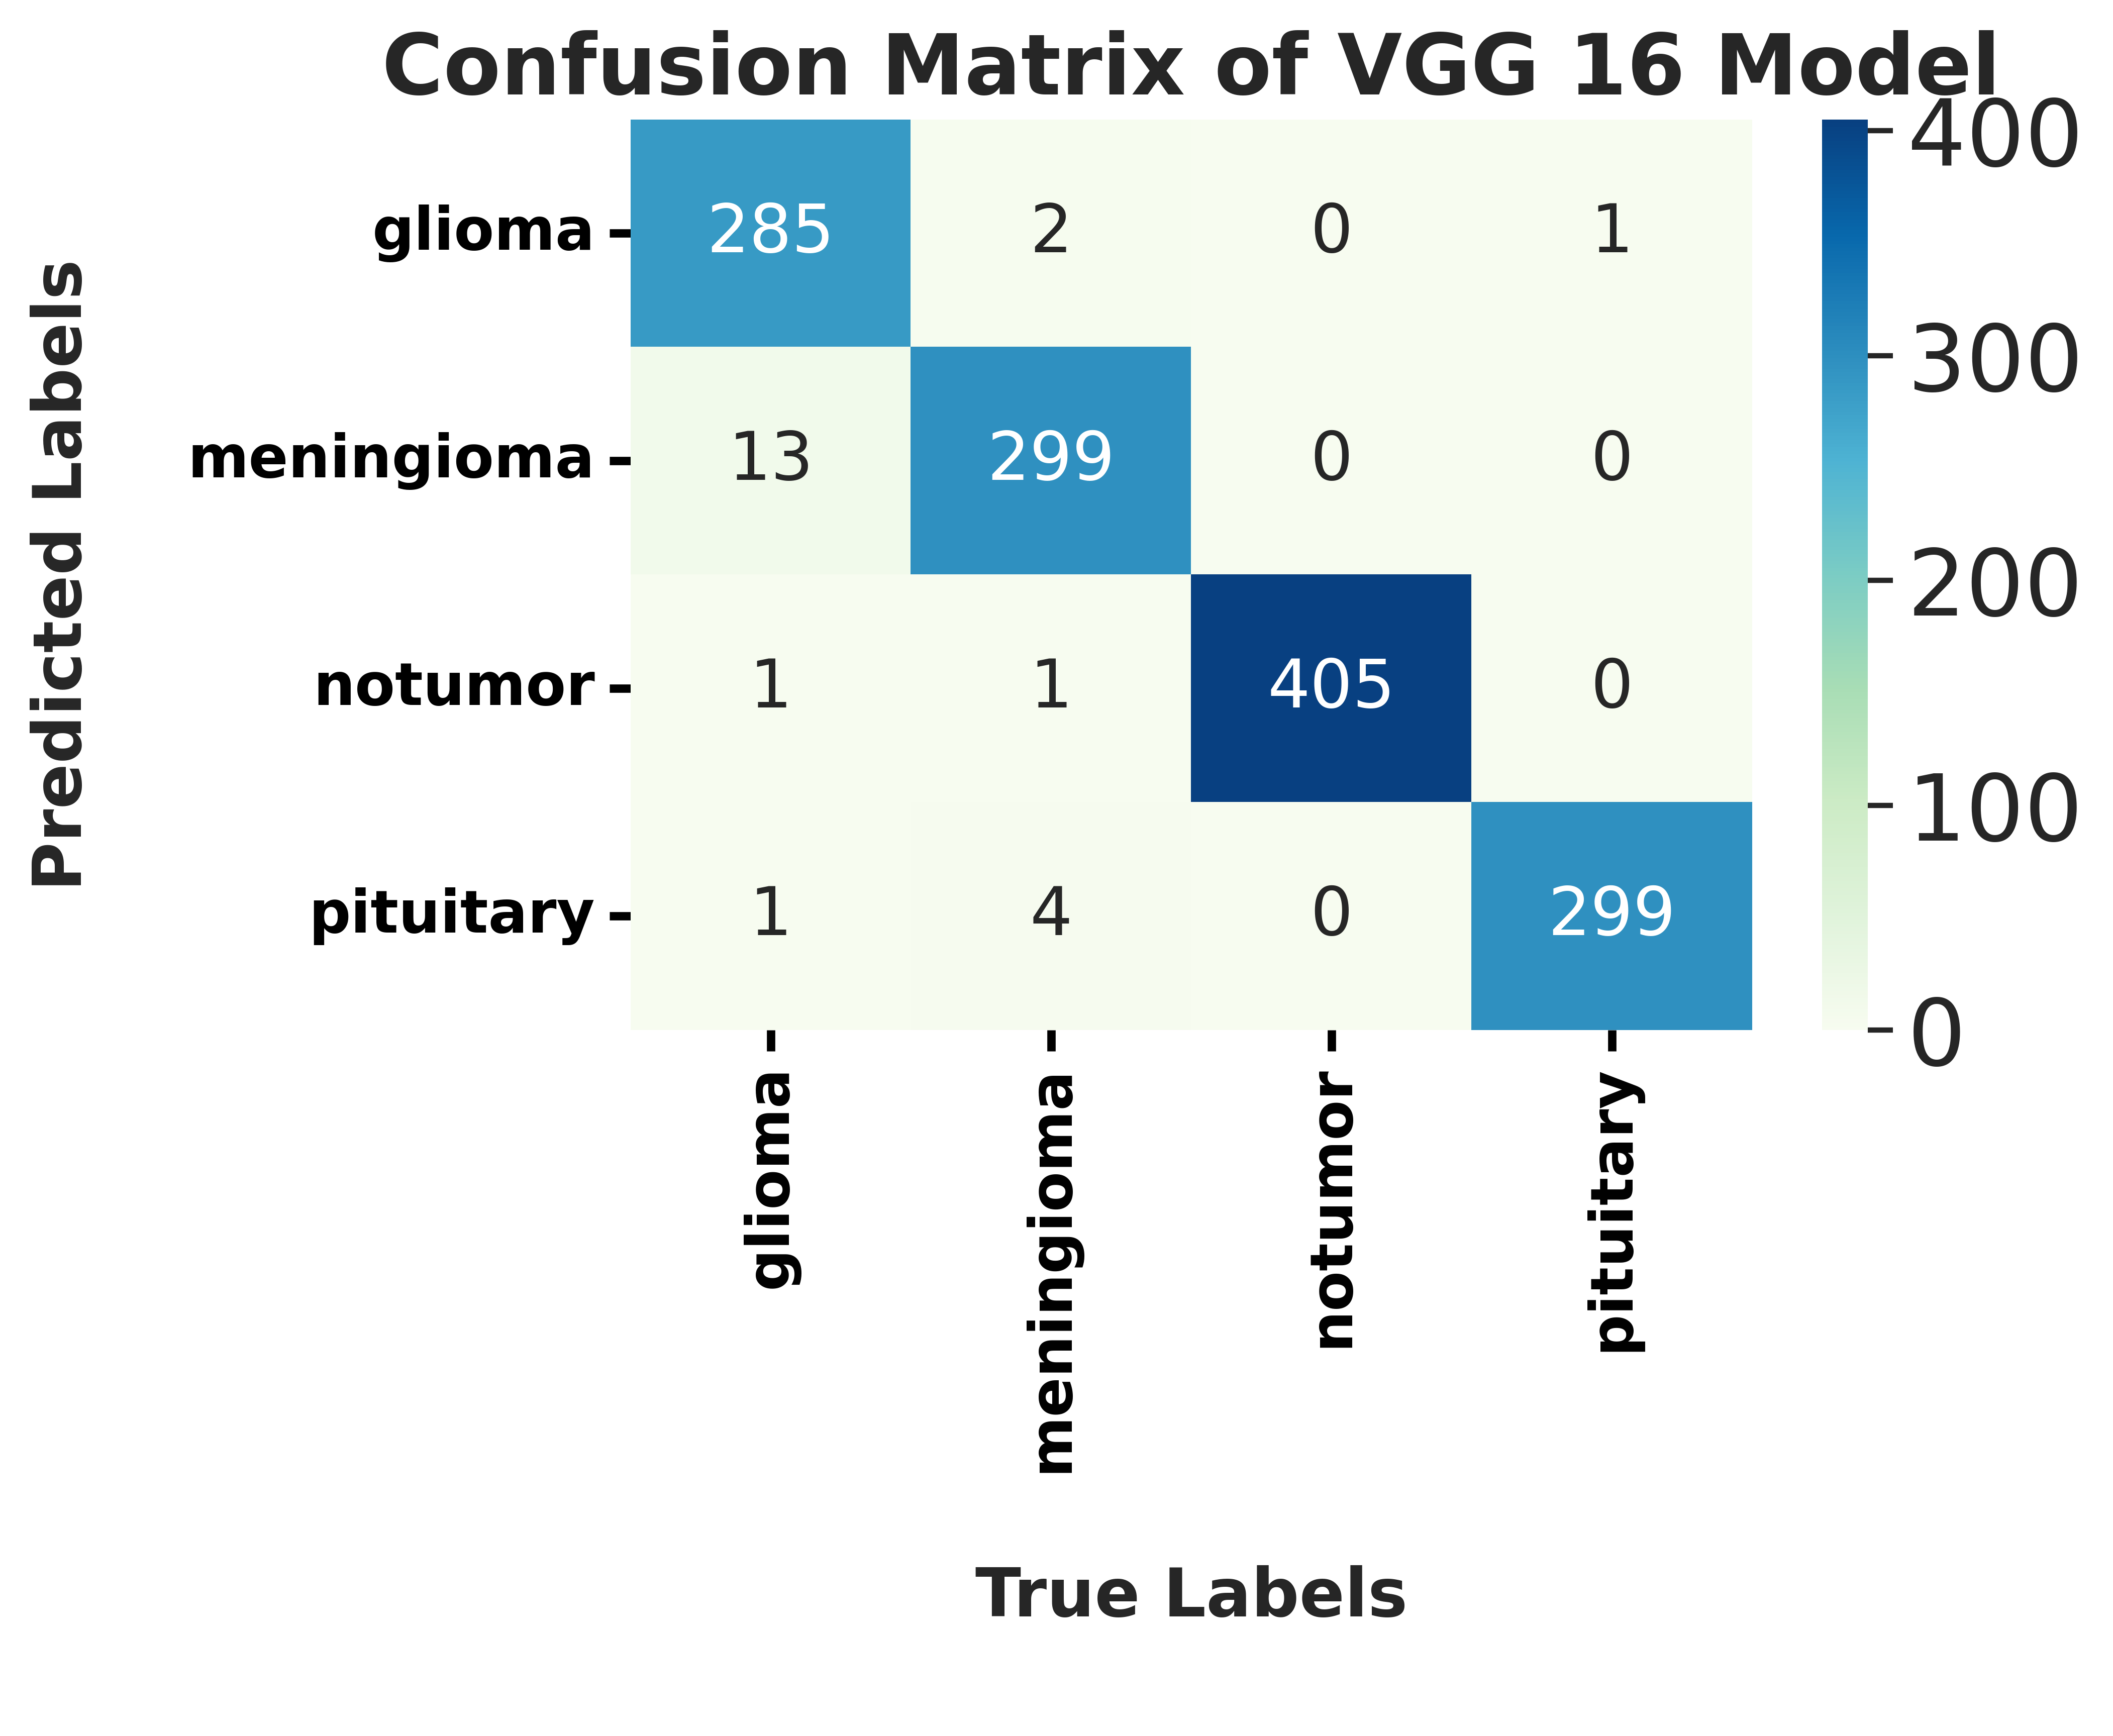

In [ ]:
predict_labels_Test = pred_test
predict_labels_Test1 = predict_labels_Test
predict_labels=np.argmax(predict_labels_Test, axis=1)
# print(predict_labels)

predict_labels_TestV2_ctg = np_utils.to_categorical(predict_labels, num_classes)
labels_Test_ctg = np_utils.to_categorical(test_generator.classes, num_classes)
predict_labels_Ar = np.asarray(predict_labels)
print("\npredict_labels_Test")
print(f'Numbre of {classes[0]} : {(predict_labels_Ar == 0).sum()}')
print(f'Numbre of {classes[1]} : {(predict_labels_Ar == 1).sum()}')
print(f'Numbre of {classes[2]} : {(predict_labels_Ar == 2).sum()}')
print(f'Numbre of {classes[3]} : {(predict_labels_Ar == 3).sum()}')

print("\n"+classification_report(predict_labels_TestV2_ctg, labels_Test_ctg))

cm = confusion_matrix(predict_labels, test_generator.classes) 
#cm1=np.array([[126, 1, 3], [0,193,9],[0,7,190]])

plt.figure()
ax= plt.subplot()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(which='major', width=1.00)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', width=0.75)
ax.tick_params(which='minor', length=2.5)
ax.tick_params(direction='out', length=5, width=2, colors='black',
               grid_color='black', grid_alpha=0.5)
sns.set(font_scale=2)
sns.heatmap(cm, annot= True, fmt='', cmap='GnBu', cbar=True, annot_kws={"size": 16})
labels=classes
plt.rcParams.update(andy_theme)
ax.set_xlabel("\nTrue Labels\n" ,fontweight="bold")
ax.set_ylabel("Predicted Labels\n" ,fontweight="bold")
ax.set_title('Confusion Matrix of VGG 16 Model',fontweight="bold"); 
ax.xaxis.set_ticklabels(labels,fontweight="bold", rotation = 90,); 
ax.yaxis.set_ticklabels(labels,fontweight="bold", rotation = 0,);

plt.show()


In [ ]:
test_classes=to_categorical(test_generator.classes)

## **ROC_AUC curve**

In [ ]:
AUC=roc_auc_score(test_classes,pred_test)
AUC  

0.9989044056978928

ROC AUC score: 0.9875918829129375


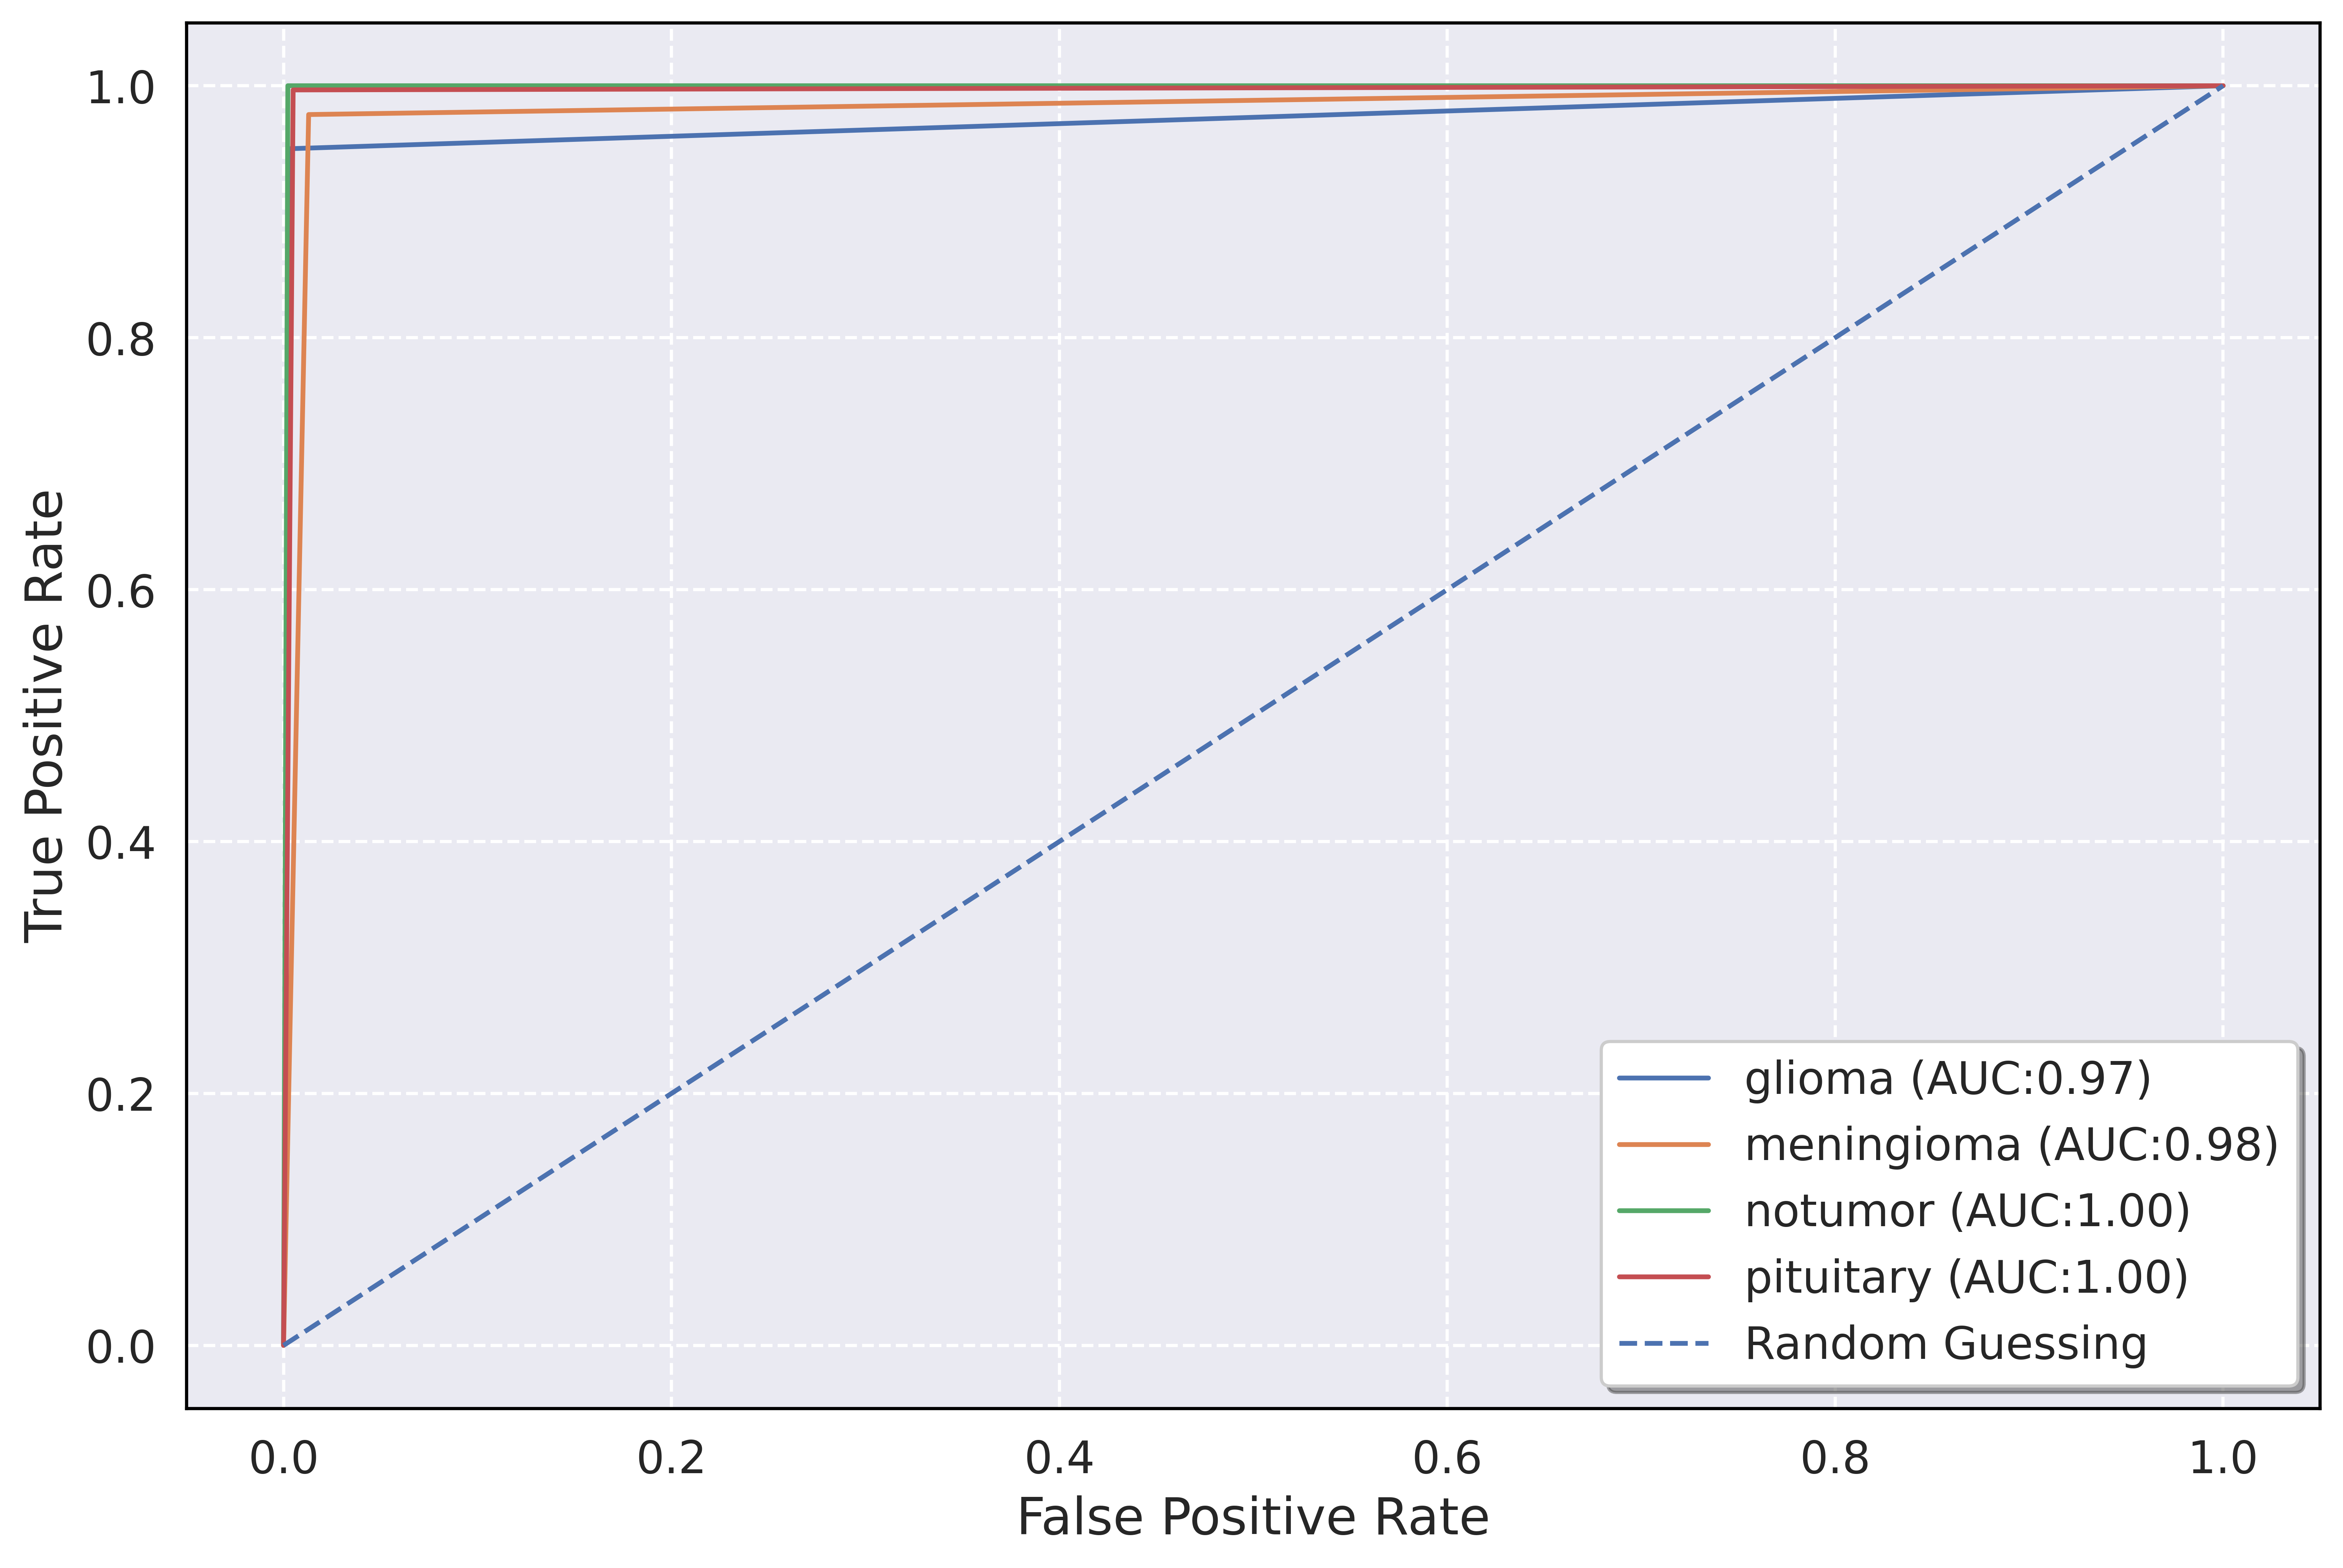

In [ ]:
target= list(test_generator.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', linestyle='--',label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test_generator.classes,predict_labels))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


In [ ]:
test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True
  )

Found 1311 images belonging to 4 classes.


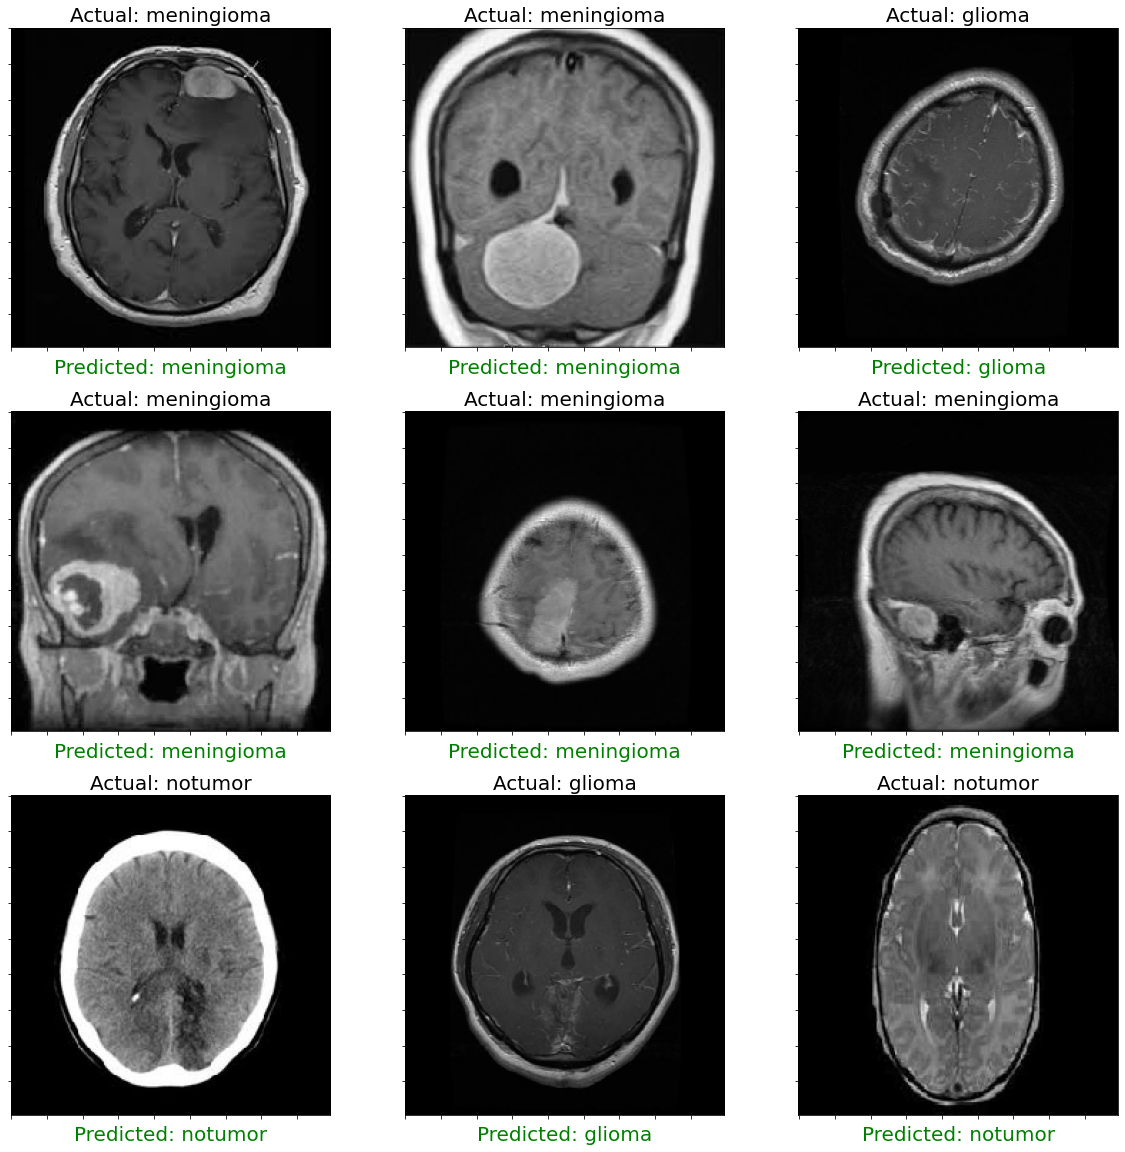

In [ ]:
images, labels = next(test_generator)
plt.figure(figsize=(20, 20))
for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        predictions = model_nw.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        v=np.where(labels[i]==np.max(labels[i]))[0][0]
        if(list(test_generator.class_indices.keys())[v]==list(test_generator.class_indices.keys())[np.argmax(score)]):
            plt.title("Actual: "+ list(test_generator.class_indices.keys())[v],fontsize=20)
            plt.xlabel("Predicted: "+ list(test_generator.class_indices.keys())[np.argmax(score)],fontsize=20,fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+ list(test_generator.class_indices.keys())[v],fontsize=20)
            plt.xlabel("Predicted: "+ list(test_generator.class_indices.keys())[np.argmax(score)],fontsize=20, fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])  
            